<a href="https://colab.research.google.com/github/yrahul3910/fastai-course/blob/master/fast_ai_Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Image Classification

In [0]:
from fastai import *
from fastai.vision import *

## Data
We use the Oxford-IIIT Pet Dataset by Parkhi et al., 2012. It has 12 cat breeds and 25 dog breeds.

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [4]:
path = untar_data(URLs.PETS)
print(path)

/root/.fastai/data/oxford-iiit-pet


In [5]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
# Use new Python3 pathlib syntax
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)

In [8]:
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_190.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_56.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_172.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_145.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_5.jpg')]

The labels are part of these filenames (example: Egyptian_Mau)

In [0]:
pattern = r'([^/]+)_\d+.jpg$'

In [10]:
help(ImageDataBunch.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path:Union[pathlib.Path, str], fnames:Collection[pathlib.Path], pat:str, valid_pct:float=0.2, **kwargs) method of builtins.type instance
    Create from list of `fnames` in `path` with re expression `pat`.



In [0]:
# Get images to the same square shape (224 x 224)
data = ImageDataBunch.from_name_re(path_img, fnames, pattern, ds_tfms=get_transforms(), size=224)

In [12]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Bombay, Category german_shorthaired, Category Sphynx, Category Sphynx, Category boxer]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 225, 300), Image (3, 500, 357), Image (3, 333, 500), Image (3, 390, 600), Image (3, 333, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category basset_hound, Category wheaten_terrier, Category saint_bernard, Category Bengal, Category staffordshire_bull_terrier]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 333, 500), Image (3, 330, 500), Image (3, 500, 375), Image (3, 325, 450), Image (3, 330, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

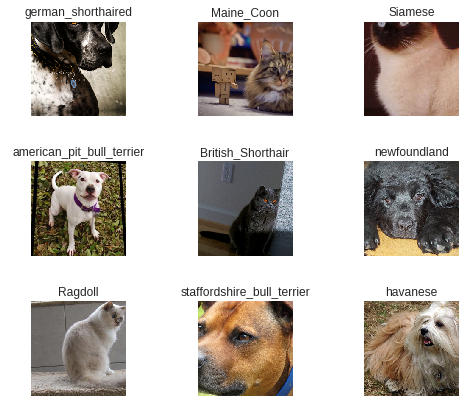

In [13]:
data.show_batch(rows=3, figsize=(7,6))

The transform function does several things, and one of the things it did was center cropping, which essentially selects the middle bit of the image and resize it. 224 x 224 is a pretty standard "just works" size for images in deep learning.

In [14]:
print(data.classes)
print(len(data.classes), data.c)  # .c gives the number of classes in classification

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37 37


## Training: ResNet34

In [15]:
# Start with a pre-trained model (transfer learning)
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 14864811.63it/s]


In [16]:
# Use One-Cycle learning by Leslie Smith (2018)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.389757,0.354150,0.104195
2,0.556048,0.268291,0.087957
3,0.355677,0.235961,0.074425
4,0.251565,0.229161,0.073748


In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

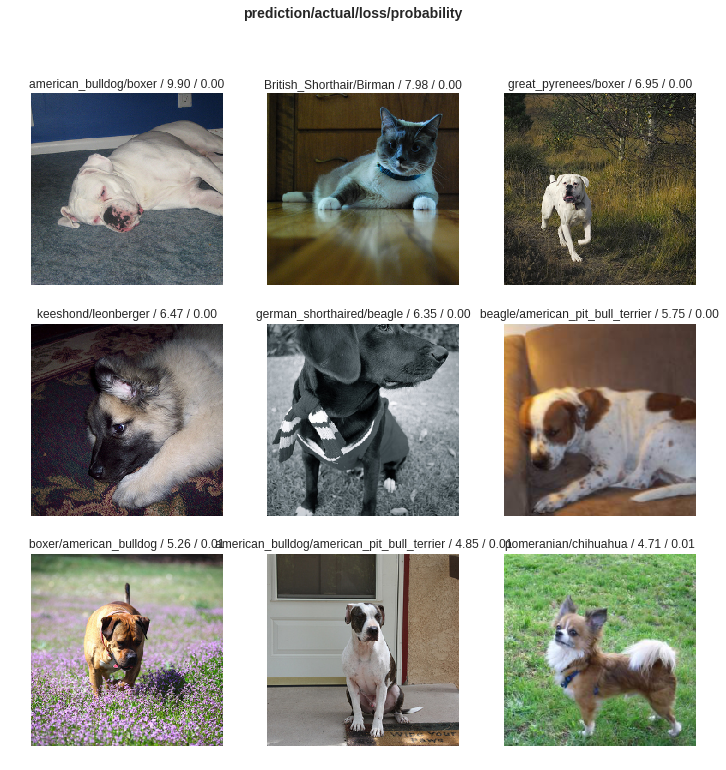

In [19]:
interp.plot_top_losses(9)

In [0]:
# Links to documentation...works on Jupyter notebook, not Colab
doc(interp.plot_top_losses)

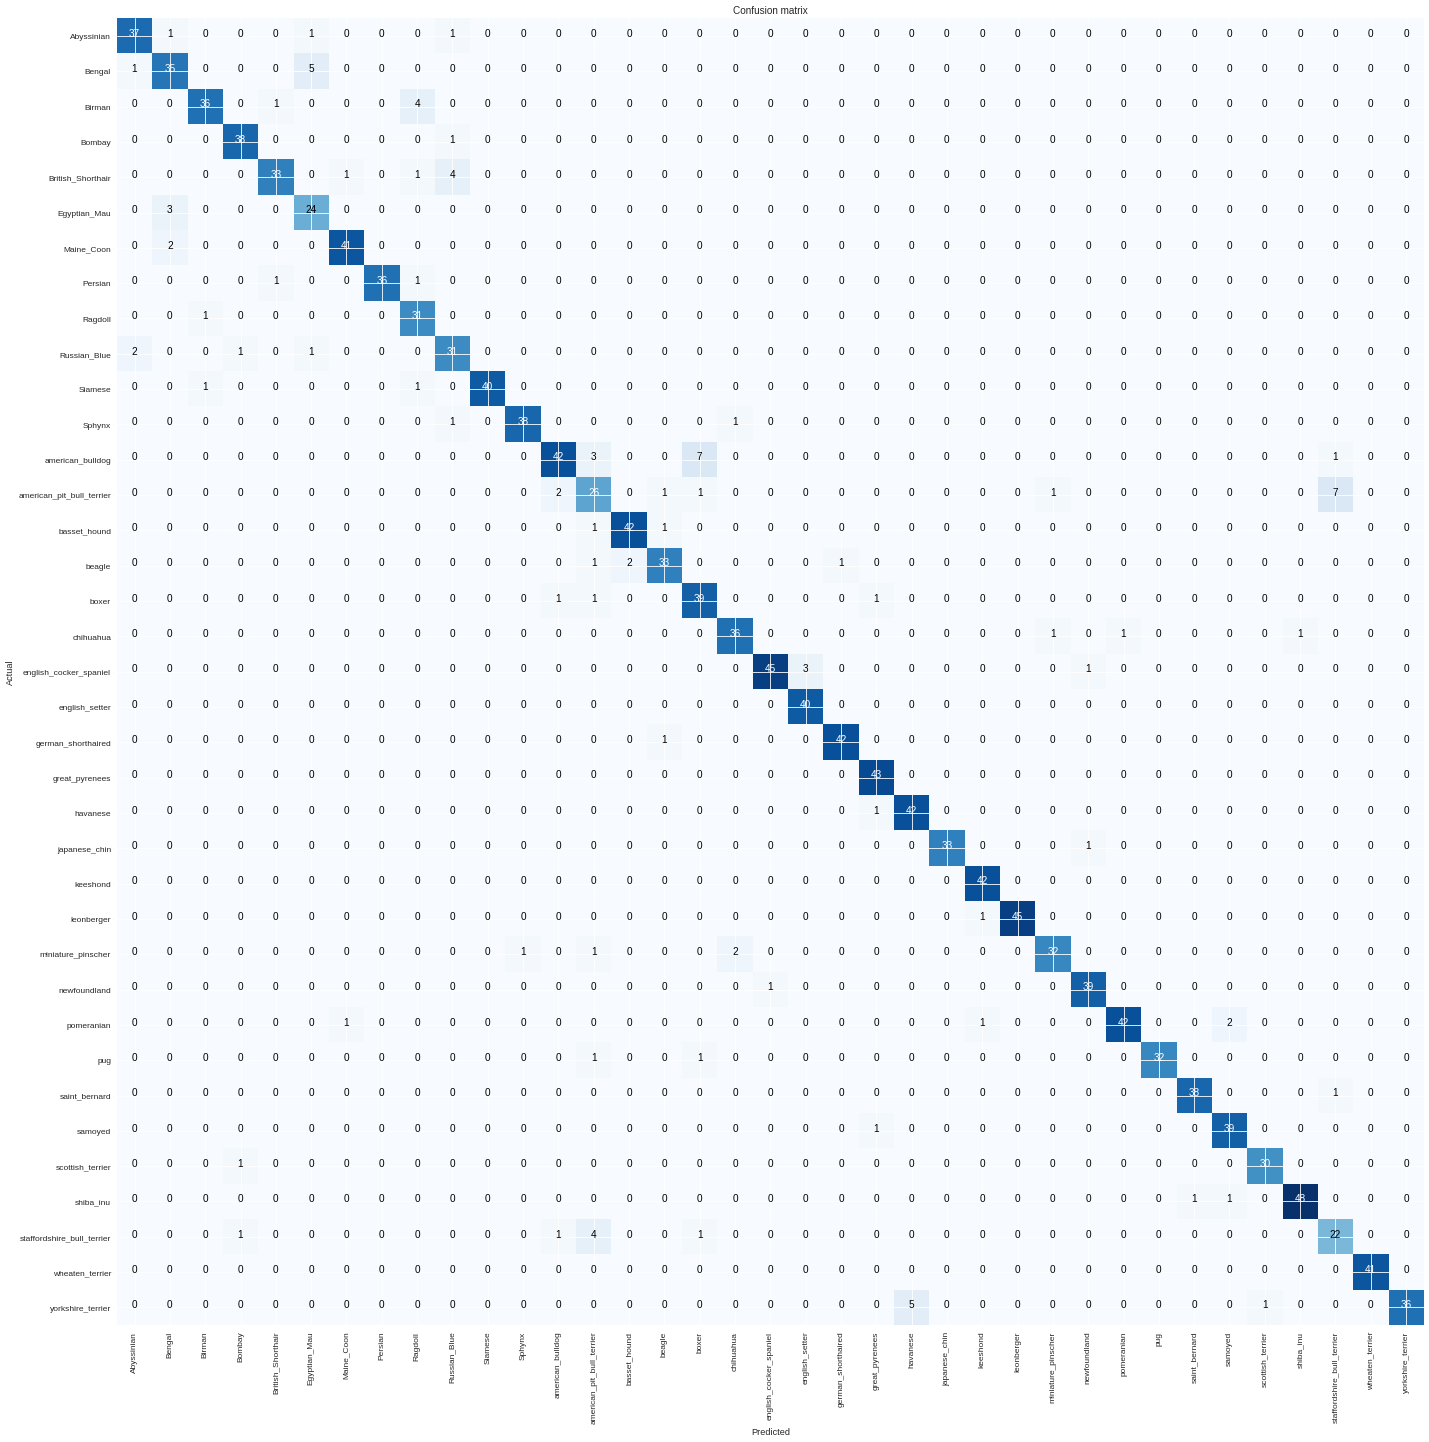

In [25]:
interp.plot_confusion_matrix(figsize=(24, 24), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('american_bulldog', 'boxer', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Bengal', 'Egyptian_Mau', 5),
 ('yorkshire_terrier', 'havanese', 5),
 ('Birman', 'Ragdoll', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('english_cocker_spaniel', 'english_setter', 3)]

## Fine-tuning, Unfreezing, and Learning Rates

In [0]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.541659,0.348588,0.104871


The loss actually got worse! To understand why, we need to look behind the scenes. See [this paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf). So layer 1, for example identifies eges. So it's unlikely that the definition of what's a diagonal edge will change across datasets. So we don't want to change the first layer, if at all. But it's likely that the last layer, which recognizes dog faces, should change.

In [29]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category Bombay, Category german_shorthaired, Category Sphynx, Category Sphynx, Category boxer]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 225, 300), Image (3, 500, 357), Image (3, 333, 500), Image (3, 390, 600), Image (3, 333, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category basset_hound, Category wheaten_terrier, Category saint_bernard, Category Bengal, Category staffordshire_bull_terrier]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 333, 500), Image (3, 330, 500), Image (3, 500, 375), Image (3, 325, 450), Image (3, 330, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, mo

In [30]:
# Will see later. Find the fastest safe learning rate
learn.lr_find()

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


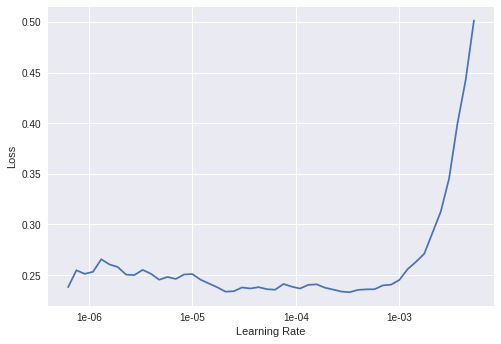

In [31]:
learn.recorder.plot()

So after about $10^{-4}$, the loss starts increasing. And since the default learning rate is about 0.003, this is why the loss was high above.

In [32]:
# There's no point training *all* the layers so slowly (1e-6), and
# we saw that training just the last few layers at 0.003 worked okay
# so we pass a range of learning rates.
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.225303,0.225015,0.070365
2,0.213581,0.215779,0.068336


## ResNet 50

In [33]:
data = ImageDataBunch.from_name_re(path_img, fnames, pattern, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 51702404.53it/s]


In [34]:
# If you get OOMError in this, then in the first line in the cell above,
# add the bs=64, bs=48, or lower parameter--this is the batch size.
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.898917,0.284527,0.092016
2,0.454416,0.227101,0.079161
3,0.278812,0.216553,0.073748
4,0.191465,0.181459,0.056157
5,0.146892,0.174887,0.053451


# Resources
* [Colab setup](https://course.fast.ai/start_colab.html)
* [Part 1 Videos](https://course.fast.ai/index.html)
* [PyTorch tutorial by Jeremy](https://pytorch.org/tutorials/beginner/nn_tutorial.html): recommendation is to view this after a few videos.
* [Detailed lecture notes](https://github.com/hiromis/notes/blob/master/Lesson1.md)
* [Building your own image dataset](https://forums.fast.ai/t/tips-for-building-large-image-datasets/26688)
* [Part 2 Videos (2018)](http://course18.fast.ai/part2.html)
* [One Cycle Learning paper, part 1](https://arxiv.org/pdf/1803.09820.pdf)
* [One Cycle Learning paper, part 2](https://arxiv.org/pdf/1708.07120.pdf)
* [CNN Visualization paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)
* [Fraud detection with Splunk and TensorFlow](https://www.splunk.com/blog/2017/04/18/deep-learning-with-splunk-and-tensorflow-for-security-catching-the-fraudster-in-neural-networks-with-behavioral-biometrics.html)